In [4]:
!pip install tensorflow


In [5]:
import tensorflow as tf  # Core TensorFlow library

from tensorflow.keras import layers, models, optimizers, callbacks  # Layers, model creation, optimizers, and training callbacks

from tensorflow.keras.models import Sequential, load_model  # For sequential model architecture and loading saved models

from tensorflow.keras.applications import EfficientNetV2B0  # Pretrained EfficientNetV2B0 model for transfer learning

from tensorflow.keras.applications.efficientnet import preprocess_input  # Preprocessing function specific to EfficientNet

import numpy as np  # Numerical operations and array handling

import matplotlib.pyplot as plt  # Plotting graphs and images

import seaborn as sns  # Plotting graphs and images

from sklearn.metrics import confusion_matrix, classification_report  # Evaluation metrics for classification models

#import gradio as gr  # Web interface library to deploy and test ML models

from PIL import Image  # For image file loading and basic image operations

In [6]:
!pip install gradio

In [7]:
import gradio as gr #for web interface. it i s library. to deploy and test ML models

In [8]:
#loading data
train_path=r'C:\Users\shrad\Downloads\E-Waste classification dataset\modified-dataset\train'
test_path=r'C:\Users\shrad\Downloads\E-Waste classification dataset\modified-dataset\test'
validate_path=r'C:\Users\shrad\Downloads\E-Waste classification dataset\modified-dataset\val'

In [9]:
#explore data
datatrain= tf.keras.utils.image_dataset_from_directory(train_path,shuffle = True, image_size = (128,128), batch_size = 32, validation_split= False)
datatest= tf.keras.utils.image_dataset_from_directory(test_path, shuffle=True, image_size=(128,128),batch_size=32, validation_split=False)
dataval= tf.keras.utils.image_dataset_from_directory(validate_path, shuffle=True,image_size=(128,128), batch_size=32, validation_split=False)

Found 2400 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 300 files belonging to 10 classes.


In [10]:
print(datatrain.class_names)
class_names=datatrain.class_names
print(len(datatrain.class_names))

['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']
10


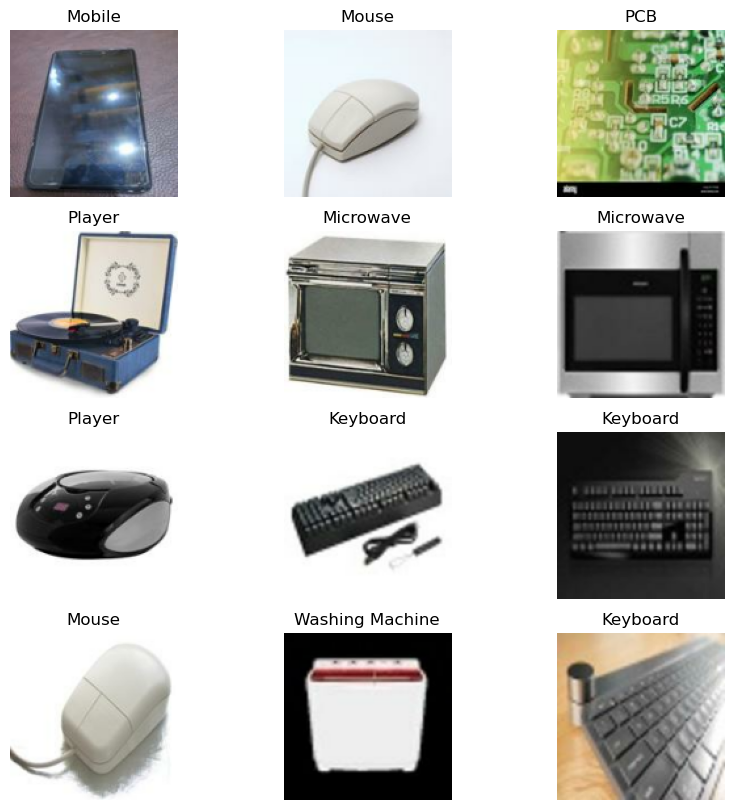

In [11]:
# Set the size of the entire figure (width=10, height=10 inches)
plt.figure(figsize=(10, 10))

# Take one batch from the dataset and iterate over the images and labels
for images, labels in datatrain.take(1):
    # Display the first 12 images from the batch
    for i in range(12):
        # Create a 4x3 grid of subplots and select the (i+1)th position
        ax = plt.subplot(4, 3, i + 1)

        # Display the image; convert the tensor to a NumPy array and ensure correct type
        plt.imshow(images[i].numpy().astype("uint8"))

        # Set the title of the subplot to the class name of the image
        plt.title(class_names[labels[i]])

        # Remove axis ticks and labels for clarity
        plt.axis("off")

In [24]:
def plot_class_distribution(dataset, title="Class Distribution"):
    """
    Plots the number of items per class in a given dataset.

    Args:
        dataset: A tf.data.Dataset object created using image_dataset_from_directory
        title: Title for the plot (e.g., 'Train Data Distribution')
    """
    class_counts = {}  # Dictionary to hold the count of each class

    # Iterate through the batches in the dataset
    for images, labels in dataset:
        for label in labels.numpy():
            class_name = dataset.class_names[label]  # Get class name using label index
            class_counts[class_name] = class_counts.get(class_name, 0) + 1

    # Prepare data for plotting
    class_names = list(class_counts.keys())
    counts = list(class_counts.values())

In [26]:
#preprocessing the data
#as all the images are of same size resizing and rescaling is not required
data_augmentation = tf.keras.Sequential ([tf.keras.layers.RandomFlip("horizontal"), tf.keras.layers.RandomRotation(0.1), tf.keras.layers.RandomZoom(0.1),])

# Load datasets from directories
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size=(128, 128),
    batch_size=32,
    shuffle=True
)

validate_dataset = tf.keras.utils.image_dataset_from_directory(
    validate_path,
    image_size=(128, 128),
    batch_size=32,
    shuffle=False
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=(128, 128),
    batch_size=32,
    shuffle=False
)
#normalize images
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(image, label):
    return preprocess_input(image), label

# Apply preprocessing
train_dataset = train_dataset.map(preprocess, num_parallel_calls=AUTOTUNE)
validate_dataset = validate_dataset.map(preprocess, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.map(preprocess, num_parallel_calls=AUTOTUNE)

Found 2400 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 300 files belonging to 10 classes.


In [28]:
#step3 model selection
#choosing effcientnetv2b0 as base model instead of direcct cnn
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False


In [30]:
#model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['Accuracy'])

In [32]:
# Define an EarlyStopping callback to stop training when validation loss stops improving
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor (validation loss here)
    patience=3,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)

In [36]:
# Set the number of epochs to train the model
epochs = 15

# Train the model on the training dataset 'datatrain'
history = model.fit(
    datatrain,                      # Training data generator or dataset
    validation_data=dataval,      # Validation data generator or dataset
    epochs=epochs,                  # Number of training epochs
    batch_size=100,                 # Number of samples per gradient update
    callbacks=[early]               # List of callbacks to apply during training (e.g., early stopping)
)

Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 54s 393ms/step - Accuracy: 0.3317 - loss: 2.0206 - val_Accuracy: 0.8133 - val_loss: 1.0012
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 26s 351ms/step - Accuracy: 0.7941 - loss: 0.9209 - val_Accuracy: 0.9333 - val_loss: 0.4405
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 27s 358ms/step - Accuracy: 0.8775 - loss: 0.4997 - val_Accuracy: 0.9367 - val_loss: 0.2755
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 418ms/step - Accuracy: 0.8973 - loss: 0.3526 - val_Accuracy: 0.9433 - val_loss: 0.2225
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 32s 425ms/step - Accuracy: 0.9421 - loss: 0.2325 - val_Accuracy: 0.9467 - val_loss: 0.1845
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 31s 410ms/step - Accuracy: 0.9447 - loss: 0.2083 - val_Accuracy: 0.9433 - val_loss: 0.1826
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 34s 455ms/step - Accuracy: 0.9535 - loss: 0.1708 - val_Accuracy: 0.9567 - val_loss: 0.1612
Epoch 8/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 33s 440ms/step - Accuracy: 0.9680 - loss: 0.1304 - val_Accu

In [38]:
### Plotting Training and Validation Accuracy and Loss Over Epochs

acc = history.history['Accuracy']           # Training accuracy
val_acc = history.history['val_Accuracy']   # Validation accuracy
loss = history.history['loss']              # Training loss
val_loss = history.history['val_loss']      # Validation loss

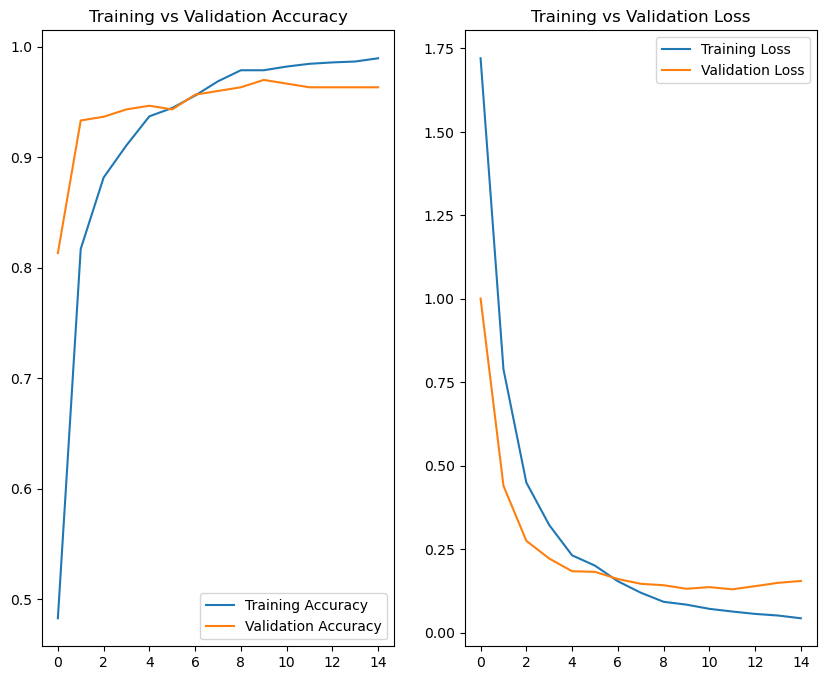

In [40]:
epochs_range = range(len(acc))              # X-axis range based on number of epochs

plt.figure(figsize=(10, 8))                 # Set overall figure size

plt.subplot(1, 2, 1)                        # 1 row, 2 columns, position 1
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')              # Show legend at lower right
plt.title('Training vs Validation Accuracy') # Set title for accuracy plot

plt.subplot(1, 2, 2)                        # 1 row, 2 columns, position 2
plt.plot(epochs_range, loss, label='Training Loss')          # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')    # Plot validation loss
plt.legend(loc='upper right')              # Show legend at upper right
plt.title('Training vs Validation Loss')    # Set title for loss plot

plt.show()                                  # Display the plots

In [42]:
loss, accuracy = model.evaluate(datatest)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - Accuracy: 0.9577 - loss: 0.1446
Test accuracy is0.9667, Test loss is 0.1200


In [44]:
### Evaluate Model Performance on Test Data using Confusion Matrix and Classification Report

# Extract true labels from all batches
y_true = np.concatenate([y.numpy() for x, y in datatest], axis=0)  # Ground truth labels

# Get predictions as probabilities and then predicted classes
y_pred_probs = model.predict(datatest)

# Class with highest probability
y_pred = np.argmax(y_pred_probs, axis=1)                           

# Print confusion matrix and classification report
print(confusion_matrix(y_true, y_pred))                            
print(classification_report(y_true, y_pred))        

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 341ms/step
[[1 2 4 4 3 5 0 5 2 4]
 [3 1 3 3 2 4 2 4 4 4]
 [0 3 3 4 5 3 4 4 2 2]
 [3 3 4 2 4 2 2 2 3 5]
 [4 1 3 4 5 2 5 1 2 3]
 [6 3 4 2 3 6 3 1 2 0]
 [2 7 1 3 2 5 3 2 2 3]
 [3 5 3 1 2 1 2 5 5 3]
 [2 2 2 3 5 2 5 1 4 4]
 [5 2 7 3 0 3 2 5 1 2]]
              precision    recall  f1-score   support

           0       0.03      0.03      0.03        30
           1       0.03      0.03      0.03        30
           2       0.09      0.10      0.09        30
           3       0.07      0.07      0.07        30
           4       0.16      0.17      0.16        30
           5       0.18      0.20      0.19        30
           6       0.11      0.10      0.10        30
           7       0.17      0.17      0.17        30
           8       0.15      0.13      0.14        30
           9       0.07      0.07      0.07        30

    accuracy                           0.11       300
   macro avg       0.11      0.11      0.11       300
weighted avg       0.11 

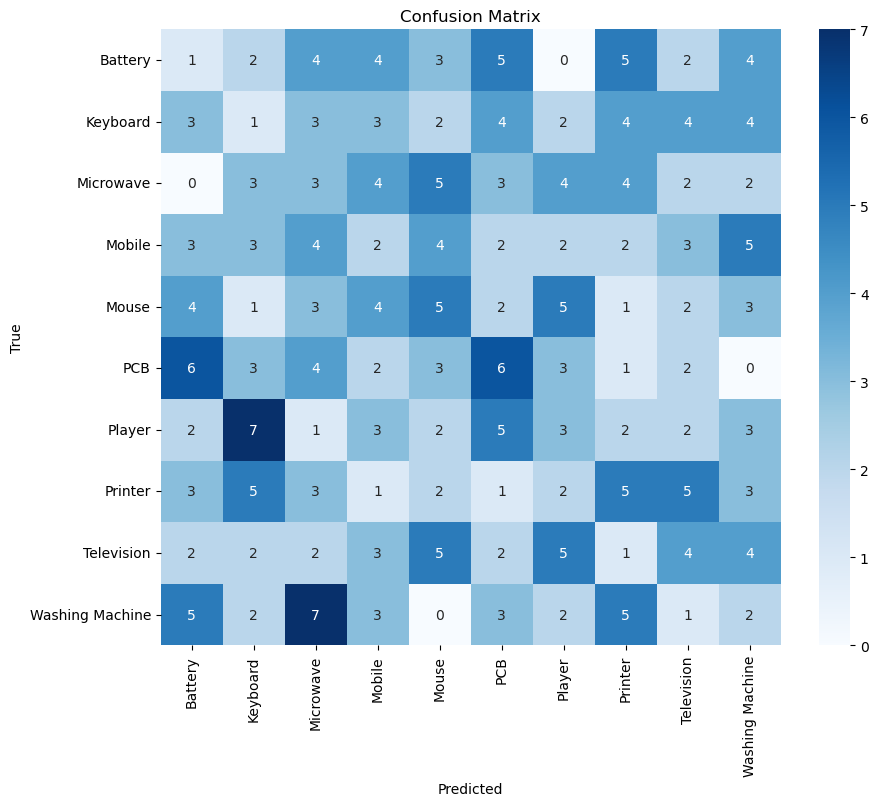

In [46]:
### Plot Confusion Matrix as Heatmap for Better Visualization

cm = confusion_matrix(y_true, y_pred)                                     # Compute confusion matrix
                                                     # Import seaborn for visualization

plt.figure(figsize=(10, 8))                                               # Set figure size
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=class_names, 
            yticklabels=class_names, 
            cmap='Blues')                                                 # Create heatmap with class labels

plt.xlabel('Predicted')                                                   # Label for x-axis
plt.ylabel('True')                                                        # Label for y-axis
plt.title('Confusion Matrix')                                             # Title for the plot
plt.show()                                                                # Display the plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


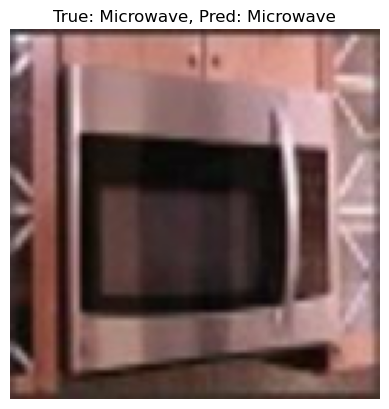

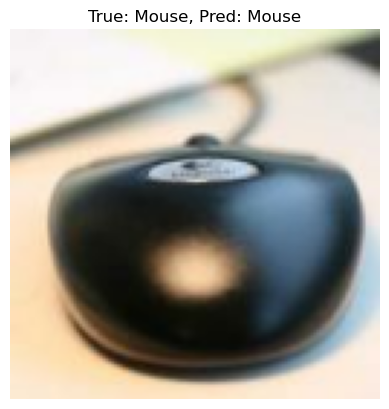

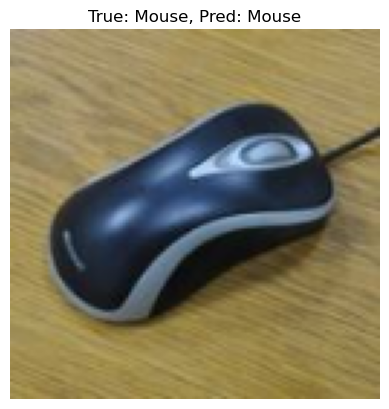

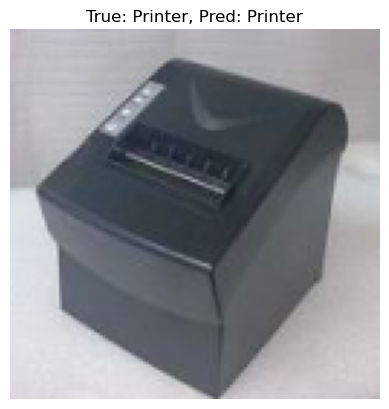

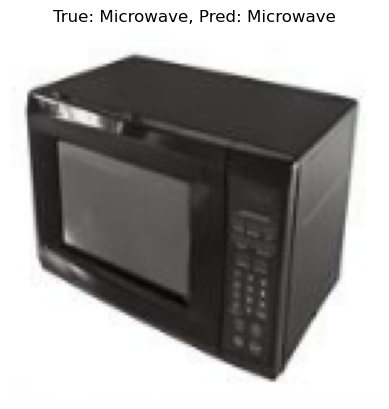

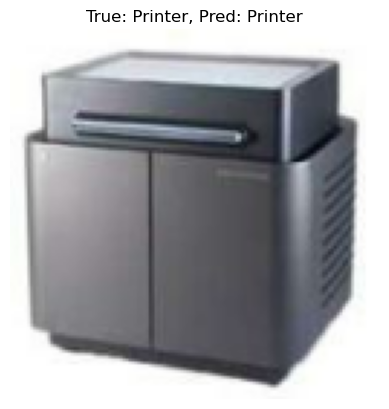

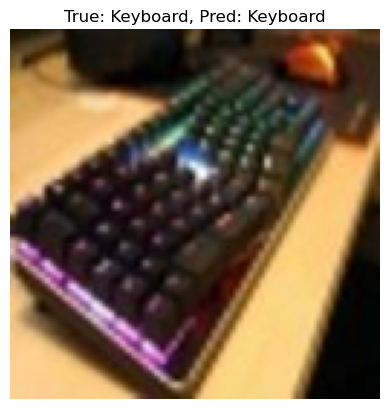

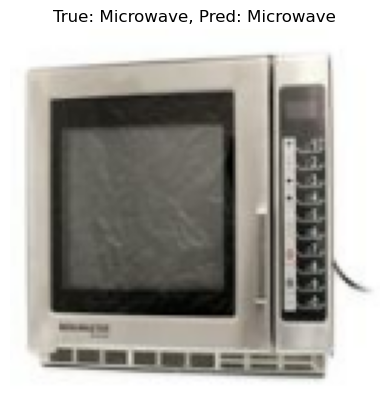

In [48]:
### Display Sample Predictions: True Labels vs Predicted Labels

class_names = datatest.class_names                                           # Get class names from test dataset

for images, labels in datatest.take(1):                                     # Take one batch from test data
    predictions = model.predict(images)                                     # Predict class probabilities
    pred_labels = tf.argmax(predictions, axis=1)                            # Get predicted class indices

    for i in range(8):                                                      # Display first 8 images from batch
        plt.imshow(images[i].numpy().astype("uint8"))                       # Convert tensor to image
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")  # Title with labels
        plt.axis("off")                                                     # Hide axes
        plt.show()               

In [50]:
# Save model in Keras format with architecture, weights, and training configuration
model.save('Efficient_classify.keras')

In [52]:
# Define your class labels
class_names = ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']

# Load your Keras model
model = tf.keras.models.load_model('Efficient_classify.keras')

In [54]:
!pip install gradio

In [56]:
def classify_image(img):
    # Step 1: Resize and convert to array
    img = img.resize((128, 128))
    img_array = np.array(img, dtype=np.float32)

    # Step 2: Preprocess and add batch dimension
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Step 3: Predict using the model
    prediction = model.predict(img_array)
    index = np.argmax(prediction)  # Get index of highest score

    # Step 4: Get class name and confidence
    class_name = class_names[index]
    confidence = prediction[0][index]

    return f"Predicted: {class_name} (Confidence: {confidence:.2f})"

In [58]:
# Create a Gradio interface for the classify_image function
iface = gr.Interface(
    fn=classify_image,          # The function to run when input is given
    inputs=gr.Image(type="pil"), # Input component: expects an image as a PIL object
    outputs="text"              # Output component: displays the result as plain text
)

# Launch the Gradio interface, opening a local web app to interact with the model
iface.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
